# How Do Skip Connections Work?


The concept of skip connections was first introduced by He et. al (2015) along with the ResNet architecture. This built upon the concept of highway networks, which allowed gated connections between layers. These breakthroughs made it possible to train much deeper networks with 100s of layers.

A 'skip connection' simply means that the input of the current layer or block of layers is added back to the output of the block.

$$
x' = x + f(x)
$$


However, it wasn't till 2018 (Li et. al) that it was understood why this improvement helped train deep networks.
So why does this work? To understand we will train two deep CNNs, each with 50 layers. The second (candidate) model will implement skip connections after each CNN filter.





## Let's Start by Looking at our Dataset


The CIFAR-10 dataset is a popular benchmark for machine learning and computer vision tasks, consisting of 60,000 32x32 color images across 10 distinct classes. Each image is labeled as one of the following categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, or truck. The dataset is divided into 50,000 training images and 10,000 test images, with an even distribution of 6,000 images per class.

Despite its simplicity, the dataset contains a variety of object poses, lighting conditions, and backgrounds, making it non-trivial to achieve high accuracy.


Convolutional Neural Networks and other image-specific architectures are typically trained on this dataset. However, for this experiment, we will use a feedforward network in order to demonstrate the benefits of using dropout.

In [1]:
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp

train_tf, test_tf = tfds.load('cifar10', split=['train', 'test'], batch_size=-1, as_supervised=True)

raw_train_images, train_labels = train_tf[0], train_tf[1]
raw_train_images = jnp.float32(raw_train_images)
raw_train_images = raw_train_images.reshape((raw_train_images.shape[0], -1))
train_labels = jnp.float32(train_labels)

raw_test_images, test_labels = test_tf[0], test_tf[1]
raw_test_images = jnp.float32(raw_test_images)
raw_test_images = raw_test_images.reshape((raw_test_images.shape[0], -1))
test_labels = jnp.float32(test_labels)

print(f"Training Set Size {raw_train_images.shape[0]}")
print(f"Test Set Size {raw_test_images.shape[0]}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.PSDFBX_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.PSDFBX_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Training Set Size 50000
Test Set Size 10000


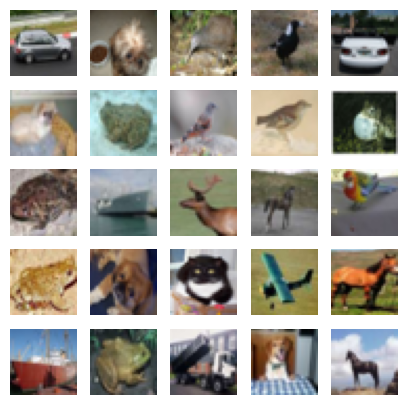

In [2]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-v0_8-darkgrid')

RANDOM_KEY = 42

num_examples = 25
row_size = int(math.sqrt(num_examples))
fig, axs = plt.subplots(row_size, row_size, figsize=(row_size,row_size))

rng = jax.random.PRNGKey(RANDOM_KEY)
idxs = jax.random.randint(rng, (num_examples,), 0, raw_train_images.shape[0])
exs = raw_train_images[idxs,:].reshape((num_examples,32,32,3))/255.0

for ex in range(num_examples):
    i = ex // row_size
    j = ex % row_size
    axs[i,j].imshow(exs[ex])
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].set_xmargin(0)
    axs[i,j].set_ymargin(0)

plt.show()

## Let's train a ResNet (NoSkip) network on CIFAR 10

In [3]:
import jax
import jax.numpy as jnp
import optax
import flax.linen as nn
from flax.training import train_state
import tensorflow_datasets as tfds

### Simple CNN Model

In [4]:
# Define the CNN model
class SimpleCNN(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool, rng=rng):
        #print(x.shape)
        x = nn.Conv(features=32, kernel_size=(3, 3))(x) # padding defaults to "SAME"
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        #print(x.shape)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        #print(x.shape)
        #print('---')

        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        #print(x.shape)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        #print(x.shape)
        #print('===')

        x = x.reshape((x.shape[0], -1))  # Flatten the tensor
        #print(x.shape)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        #print(x.shape)
        x = nn.Dense(features=10)(x)  # 10 classes for CIFAR-10
        #print(x.shape)
        #print('ooo')
        return x

### Deep CNN Network

In [5]:
# Define the CNN model


init = nn.initializers.he_normal()

class ConvBlock(nn.Module):

    stride: int
    filters: int

    @nn.compact
    def __call__(self, x, train):

        x = nn.Conv(features=self.filters, kernel_size=(3, 3), strides=self.stride, padding='SAME', use_bias=False, kernel_init=init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)
        x = nn.relu(x)

        x = nn.Conv(features=self.filters, kernel_size=(3, 3), strides=1, padding='SAME', use_bias=False, kernel_init=init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)
        return nn.relu(x)


class DeepCNN(nn.Module):

    @nn.compact
    def __call__(self, x, train: bool):

        x = nn.Conv(features=16, kernel_size=(3, 3), strides=1, padding=1, use_bias=False, kernel_init=init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)
        x = nn.relu(x)

        x = ConvBlock(stride=1, filters=16)(x, train)
        x = ConvBlock(stride=1, filters=16)(x, train)
        x = ConvBlock(stride=1, filters=16)(x, train)

        x = ConvBlock(stride=2, filters=32)(x, train)
        x = ConvBlock(stride=1, filters=32)(x, train)
        x = ConvBlock(stride=1, filters=32)(x, train)

        x = ConvBlock(stride=2, filters=64)(x, train)
        x = ConvBlock(stride=1, filters=64)(x, train)
        x = ConvBlock(stride=1, filters=64)(x, train)

        x = nn.avg_pool(x, window_shape=(x.shape[1], x.shape[2]))
        x = x.reshape((x.shape[0], -1))  # Flatten

        x = nn.Dense(features=10, kernel_init=init)(x)  # Output layer for 10 classes


        return x

### CNN with Residual Connection

In [6]:
# Define the CNN model

from flax.linen import Module

init = nn.initializers.he_normal()

class ShortcutLayer(Module):

    stride: int
    planes: int  # Number of output channels after padding

    @staticmethod
    def pad_channels(x, target_planes):
        """Pad the channel dimension to match target_planes."""
        input_planes = x.shape[-1]
        pad_planes = target_planes - input_planes
        if pad_planes >= 0:
          # Compute padding for the channel dimension
          pad = [(0, 0), (0, 0), (0, 0), (pad_planes // 2, pad_planes - pad_planes // 2)]
          return jnp.pad(x, pad, mode='constant', constant_values=0)
        return x

    def __call__(self, x):
        # Downsample spatial dimensions by strided slicing
        x = x[:, ::self.stride, ::self.stride, :]
        # Pad channel dimensions to `planes`
        x = self.pad_channels(x, self.planes)
        return x


class ResidualBlock(nn.Module):

    stride: int
    filters: int

    @nn.compact
    def __call__(self, x, train):
        residual = x

        x = nn.Conv(features=self.filters, kernel_size=(3, 3), strides=self.stride, padding="SAME", use_bias=False, kernel_init=init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)
        x = nn.relu(x)

        x = nn.Conv(features=self.filters, kernel_size=(3, 3), strides=1, padding="SAME", use_bias=False, kernel_init=init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)

        x += ShortcutLayer(self.stride, self.filters)(residual)

        return nn.relu(x)


class ResidualCNN(nn.Module):

    @nn.compact
    def __call__(self, x, train: bool):

        x = nn.Conv(features=16, kernel_size=(3, 3), strides=1, padding="SAME", use_bias=False, kernel_init=init)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.1, epsilon=1e-5)(x)

        x = ResidualBlock(stride=1, filters=16)(x, train)
        x = ResidualBlock(stride=1, filters=16)(x, train)
        x = ResidualBlock(stride=1, filters=16)(x, train)

        x = ResidualBlock(stride=2, filters=32)(x, train)
        x = ResidualBlock(stride=1, filters=32)(x, train)
        x = ResidualBlock(stride=1, filters=32)(x, train)

        x = ResidualBlock(stride=2, filters=64)(x, train)
        x = ResidualBlock(stride=1, filters=64)(x, train)
        x = ResidualBlock(stride=1, filters=64)(x, train)

        x = nn.avg_pool(x, window_shape=(x.shape[1], x.shape[2]))
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=10, kernel_init=init)(x)  # Output layer for 10 classes

        return x

In [7]:
BATCH_SIZE = 128

import tensorflow as tf
import tensorflow_datasets as tfds
import torchvision.transforms as transforms
import jax.numpy as jnp

# Load CIFAR-10 dataset
def load_data():

  ds_train, ds_test = tfds.load(
      'cifar10', split=['train', 'test'], as_supervised=True)

  return ds_train, ds_test

mean = [125.3/255.0, 123.0/255.0, 113.9/255.0]
std = [63.0/255.0, 62.1/255.0, 66.7/255.0]

def preprocess_train(image, label):

  # Normalize the image
  image = tf.cast(image, tf.float32) / 255.0

  # Apply data augmentation (e.g., random flip)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_crop(image, [32, 32, 3])
  image = (image - mean)/std
  return image, label


def preprocess_test(image, label):

  # Normalize the image
  image = tf.cast(image, tf.float32) / 255.0

  # Apply data augmentation (e.g., random flip)
  image = (image - mean)/std
  return image, label


In [8]:
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils import data


def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class FlattenAndCast(object):
    def __call__(self, pic):
        return np.array(pic.permute(1, 2, 0), dtype=jnp.float32)

class NumpyLoader(data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        timeout=0,
        worker_init_fn=None,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
        )


transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(
        (32, 32),
        padding=4,
        fill=0,
        padding_mode="constant"
    ),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]
    ),
    FlattenAndCast(),
])

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]
        ),
        FlattenAndCast(),
    ]
)

train_dataset = CIFAR10(
    root="./CIFAR", train=True, download=True, transform=transforms_train
)

test_dataset = CIFAR10(
    root="./CIFAR", train=False, download=True, transform=transforms_test
)

train_loader = NumpyLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=False
)

test_loader= NumpyLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=BATCH_SIZE,
    pin_memory=False
)



100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./CIFAR/cifar-10-python.tar.gz to ./CIFAR
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
LEARNING_RATE = 0.1
NUM_EPOCHS = 200



def count_parameters(params):
    return sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, params)))

# Create the train state
def create_train_state(rng, cnn, train_size, learning_rate):
    variables = cnn.init(rng, jnp.ones([1, 32, 32, 3]), True)
    params = variables['params']

    num_params = count_parameters(params)
    print(f"Initialized model with {num_params} parameters")

    batch_stats = None
    if "batch_stats" in variables:
        batch_stats = variables['batch_stats']

    steps_per_epoch = train_size//BATCH_SIZE

    lr_schedule = optax.schedules.piecewise_constant_schedule(init_value=LEARNING_RATE,
                                                              boundaries_and_scales={100*steps_per_epoch: 0.1, 150*steps_per_epoch: 0.1})

    # Configure the optimizer
    tx = optax.sgd(learning_rate=lr_schedule,
                   momentum=0.9, nesterov=True)
    tx = optax.chain(
        tx,
        optax.add_decayed_weights(1e-5)
    )

    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx), batch_stats


# Define the training and evaluation steps
@jax.jit
def train_step(state, images, labels, batch_stats):

    def loss_fn(params, batch_stats):
        logits, outputs = state.apply_fn({'params': params, 'batch_stats': batch_stats}, images, train=True, mutable=["batch_stats"])

        updated_batch_stats = outputs['batch_stats']

        one_hot = jax.nn.one_hot(labels, num_classes=10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits, one_hot))
        return loss, (updated_batch_stats, logits)


    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    outputs, grads = grad_fn(state.params, batch_stats)
    loss, aux  = outputs
    updated_batch_stats, logits = aux
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    grads_flat = jax.tree_util.tree_flatten(grads)[0][2]
    grad_norm = jnp.linalg.norm(grads_flat)
    state = state.apply_gradients(grads=grads)
    return state, loss, accuracy, updated_batch_stats


@jax.jit
def eval_step(state, images, labels, batch_stats):
    logits = state.apply_fn({'params': state.params, 'batch_stats': batch_stats}, images, train=False)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy


# Initialize data lists
epochs = []
accuracies = []

# Training loop
def train_and_evaluate(model, num_epochs, batch_size, learning_rate):

    rng = jax.random.PRNGKey(0)

    # Create the train state
    state, batch_stats = create_train_state(rng, model, 50000, learning_rate)

    iter = 0
    # Prepare data batches
    for epoch in range(num_epochs):

        # Training
        train_losses = []
        train_accuracies = []
        for images, labels in train_loader:

            state, loss, accuracy, batch_stats = train_step(state, images, labels, batch_stats)
            train_losses.append(loss)
            train_accuracies.append(accuracy)
            iter += 1

        # Evaluation
        test_accuracies = []
        for images, labels in test_loader:

            accuracy = eval_step(state, images, labels, batch_stats)
            test_accuracies.append(accuracy)

        # Compute mean loss
        mean_epoch_loss = jnp.mean(jnp.array(train_losses))
        # Compute mean accuracy
        train_accuracy = jnp.mean(jnp.array(train_accuracies))  # Convert to JAX array
        test_accuracy = jnp.mean(jnp.array(test_accuracies))  # Convert to JAX array

        print(f"Iter: {iter + 1}, Epoch {epoch + 1}, Train Loss: {mean_epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return state


# Run the training
model = DeepCNN()
trained_state = train_and_evaluate(model=model, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)


Initialized model with 269722 parameters


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter: 392, Epoch 1, Train Loss: 1.6954, Train Accuracy: 0.3627, Test Accuracy: 0.4455


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Iter: 783, Epoch 2, Train Loss: 1.2753, Train Accuracy: 0.5390, Test Accuracy: 0.6029
Iter: 1174, Epoch 3, Train Loss: 0.9794, Train Accuracy: 0.6487, Test Accuracy: 0.6765
Iter: 1565, Epoch 4, Train Loss: 0.8283, Train Accuracy: 0.7090, Test Accuracy: 0.7365
Iter: 1956, Epoch 5, Train Loss: 0.7353, Train Accuracy: 0.7420, Test Accuracy: 0.7641
Iter: 2347, Epoch 6, Train Loss: 0.6695, Train Accuracy: 0.7676, Test Accuracy: 0.7811
Iter: 2738, Epoch 7, Train Loss: 0.6150, Train Accuracy: 0.7882, Test Accuracy: 0.7828
Iter: 3129, Epoch 8, Train Loss: 0.5797, Train Accuracy: 0.7984, Test Accuracy: 0.7934
Iter: 3520, Epoch 9, Train Loss: 0.5468, Train Accuracy: 0.8105, Test Accuracy: 0.8114
Iter: 3911, Epoch 10, Train Loss: 0.5159, Train Accuracy: 0.8222, Test Accuracy: 0.8159
Iter: 4302, Epoch 11, Train Loss: 0.4964, Train Accuracy: 0.8281, Test Accuracy: 0.8189
Iter: 4693, Epoch 12, Train Loss: 0.4767, Train Accuracy: 0.8347, Test Accuracy: 0.8219
Iter: 5084, Epoch 13, Train Loss: 0.4559,

| Model        | Conv Layers  |50 epochs. | 100 epochs | 200 epochs |
|--------------|--------------|-----------|------------|------------|
| DeepCNN      | 20           |  0.8720   |  0.8808    |  0.8860    |
| ResCNN       | 20           |  0.8861   |  0.8881    |  0.8985    |   

## Next, Let's train a ResNet with Skip Connections

## So Why do Skip Connections Work?

### Let's Plot the Loss Surfaces

### References:

1. Highway networks - Srivastava et. al (2015)
2. "Deep Residual Learning for Image Recognition" by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun, published in 2015
2. ON LARGE-BATCH TRAINING FOR DEEP LEARNING: GENERALIZATION GAP AND SHARP MINIMA - Keskar et. al
3. An empirical analysis of the optimization of deep network loss surfaces - Im et. al (2017)
4. Hao Li1, Zheng Xu1, Gavin Taylor2, Christoph Studer3, Tom Goldstein1 - Visualizing the Loss Landscape of Neural Nets (2018)